# Homework 1 - Problem 2

Reload data from the open data portal

In [1]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

client = Socrata("data.cityofchicago.org", None)
results = client.get("6zsd-86xi", where="year=2017 OR year=2018",limit=1000000)
results_df = pd.DataFrame.from_records(results)

Note: source consulted for geomerge https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html

Convert into geodataframe to be able to merge to census API
First, load necessary packages

In [2]:
import geopandas
import shapefile as shp
from shapely.geometry import Point

Create coordinate object to use as shapely object

In [3]:
results_df['latitude'] = pd.to_numeric(results_df['latitude'])
results_df['longitude'] = pd.to_numeric(results_df['longitude'])
results_df.dropna(axis=0, how='any',subset=['latitude','longitude'], inplace=True)
results_df['Coordinates'] = list(zip(results_df.longitude, results_df.latitude))
results_df['Coordinates'] = results_df['Coordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(results_df, geometry='Coordinates')

Now, load ACS data via census API 
(source consulted - documentation)

In [4]:
import pandas as pd
import requests

In [5]:
#Make the API requests - variables' names updated below to reflect pulls; attempting to look at income, race, and employment levels
request_obj = requests.get('https://api.census.gov/data/2017/acs/acs5/?get=NAME,B19013_001E,B03002_003E,B03002_001E,B23025_005E,B23025_003E&for=block%20group:*&in=state:17%20county:031')
json2 = request_obj.json()
df_2 = pd.DataFrame(json2)
df_2.columns = df_2.iloc[0]
df_2 = df_2.drop(df_2.index[0])
df_2 = df_2.rename(columns={'B19013_001E': 'median_income', 'B23025_005E': 'unemployed','B23025_003E': 'labor_force', 'B03002_003E': 'non_hisp_white','B03002_001E': 'total'})
df_2['unemployed'] = pd.to_numeric(df_2['unemployed'])
df_2['labor_force'] = pd.to_numeric(df_2['labor_force'])
df_2['percent_unemp'] = df_2['unemployed']/df_2['labor_force']
df_2['non_hisp_white'] = pd.to_numeric(df_2['non_hisp_white'])
df_2['total'] = pd.to_numeric(df_2['total'])
df_2['percent_white'] = df_2['non_hisp_white']/df_2['total']
df_2.head(1)

,NAME,median_income,non_hisp_white,total,unemployed,labor_force,state,county,tract,block group,percent_unemp,percent_white
1,"Block Group 1, Census Tract 2519, Cook County,...",21500,11,600,67,209,17,031,251900,1,0.320574,0.018333


In [6]:
#Create shapefile to use with census data to get locations
shp_path = "./tl_2018_17_bg.shp"
location_match = geopandas.read_file(shp_path)

In [7]:
new_df = df_2.merge(location_match,how='left',left_on=['tract','block group'],right_on=['TRACTCE','BLKGRPCE'])
new_df.head(1)

,NAME,median_income,non_hisp_white,total,unemployed,labor_force,state,county,tract,block group,...,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,"Block Group 1, Census Tract 2519, Cook County,...",21500,11,600,67,209,17,031,251900,1,...,1,170312519001,Block Group 1,G5030,S,117328,0,+41.8838925,-087.7593102,"POLYGON ((-87.76035399999999 41.887358, -87.76..."


In [8]:
#Convert to geodf
census_gdf = geopandas.GeoDataFrame(new_df, geometry='geometry')

In [9]:
#Grab only the columns that we want to make the df easier to manage
census_gdf = census_gdf[['NAME','median_income','tract', 'block group',
       'percent_unemp', 'percent_white', 'geometry']]
census_gdf.head(1)

,NAME,median_income,tract,block group,percent_unemp,percent_white,geometry
0,"Block Group 1, Census Tract 2519, Cook County,...",21500,251900,1,0.320574,0.018333,"POLYGON ((-87.76035399999999 41.887358, -87.76..."


In [10]:
#now merge with the data from the crime portal
census_merge = geopandas.sjoin(gdf, census_gdf, how="inner", op='intersects')

Now, we can take a look at characteristics from the high crime wards as ascertained in question 1

In [11]:
#Ward 28 had the highest violent crime
ward_28 = census_merge[census_merge['ward'] == '28']
print('Median income:', ward_28.iloc[0]['median_income'])
print('Percent unemployment:',"{0:.2f}".format(ward_28.iloc[0]['percent_unemp']))
print('Percent white:'"{0:.2f}".format(ward_28.iloc[0]['percent_white']))

Median income: 38232
Percent unemployment: 0.11
Percent white:0.05


We can see that in this ward, the mean income is 38,000; unemployment is over 11%, and only 5% of the population is white.

In [12]:
#Ward 42 had the highest overall crime reports -- looking at all types
ward_42 = census_merge[census_merge['ward'] == '42']
print('Median income:', ward_42.iloc[0]['median_income'])
print('Percent unemployment:',"{0:.2f}".format(ward_42.iloc[0]['percent_unemp']))
print('Percent white:',"{0:.2f}".format(ward_42.iloc[0]['percent_white']))

Median income: 148665
Percent unemployment: 0.04
Percent white: 0.69


In contrast, in ward 42, the median income is almost 150,000 a year; the unemployment rate is ~4% and ~68% of the population is white.

Now, let's look at battery as outlined in the question

In [13]:
battery = results_df.loc[results_df["primary_type"] == 'BATTERY']
ward_year = battery.groupby(["ward","year"]).size()
ward_year = ward_year.unstack()
ward_year_sorted = ward_year.sort_values(by='2018',ascending=False)
ward_year_sorted

year,2017,2018
ward,,
28,2632,2633
24,2662,2545
17,2112,2084
6,1852,1920
20,1923,1853
42,1582,1820
27,1545,1751
7,1712,1692
3,1555,1642


From the above table, we can see that ward 28 had the highest instance of battery in 2018, followed 24, which is the second highest instance of battery.

In [14]:
ward_28 = census_merge[census_merge['ward'] == '28']
print('Median income', ward_28.iloc[0]['median_income'])
print('Percent unemployment:', "{0:.2f}".format(ward_28.iloc[0]['percent_unemp']))
print('Percent white:', "{0:.2f}".format(ward_28.iloc[0]['percent_white']))

Median income 38232
Percent unemployment: 0.11
Percent white: 0.05


In [15]:
ward_24 = census_merge[census_merge['ward'] == '24']
print('Median income', ward_24.iloc[0]['median_income'])
print('Percent unemploymemt',"{0:.2f}".format(ward_24.iloc[0]['percent_unemp']))
print('Percent white',"{0:.2f}".format(ward_24.iloc[0]['percent_white']))

Median income 25714
Percent unemploymemt 0.08
Percent white 0.09


We can see that both of these are neighborhoods with low income, higher unemployment and higher non-white populations. Replicating this analysis for homicides instead of battery indicates the same neighborhoods suffering from highest rates as above.

In [16]:
homicide = results_df.loc[results_df["primary_type"] == 'HOMICIDE']
ward_hom = homicide.groupby(["ward","year"]).size()
ward_hom = ward_hom.unstack()
ward_hom_sorted = ward_hom.sort_values(by='2018',ascending=False)
ward_hom_sorted.fillna(0.0,inplace=True)
ward_hom_sorted

year,2017,2018
ward,,
28,48.0,59.0
24,54.0,42.0
16,29.0,41.0
9,26.0,35.0
37,28.0,29.0
34,30.0,29.0
3,28.0,27.0
6,30.0,26.0
17,22.0,24.0


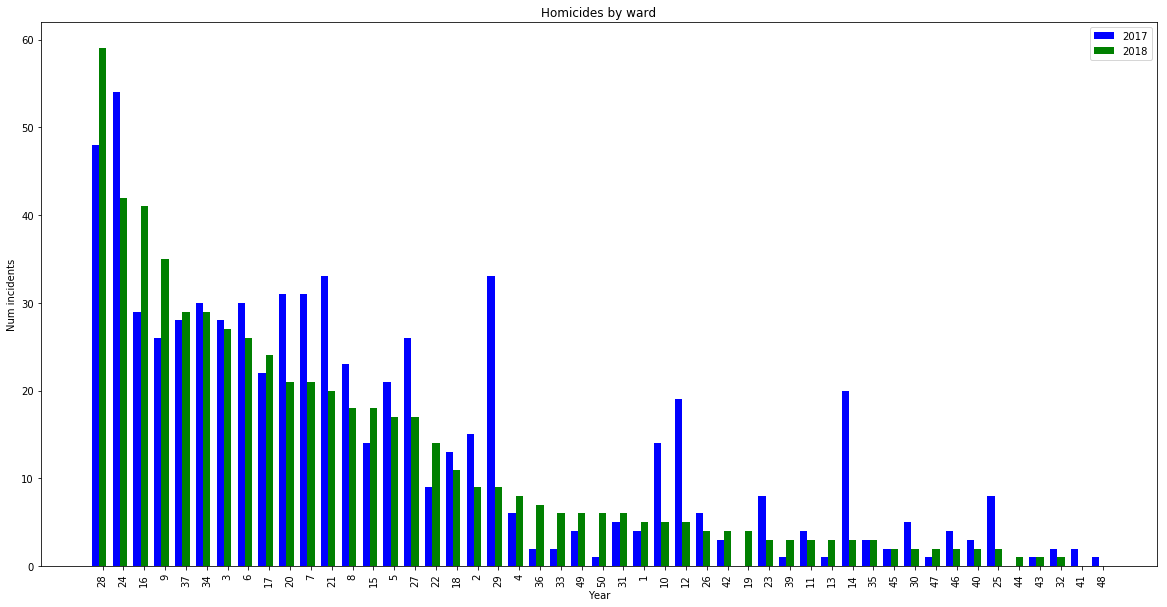

In [17]:
n = ward_hom_sorted.shape[0]
num_2017 = ward_hom_sorted['2017']
num_2018 = ward_hom_sorted['2018']
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n)
bar_width = 0.35
rects1 = plt.bar(index, num_2017, bar_width,
color='b',
label='2017')

rects2 = plt.bar(index + bar_width, num_2018, bar_width,
color='g',
label='2018')

plt.xlabel('Year')
plt.ylabel('Num incidents')
plt.title('Homicides by ward')
plt.xticks(index + bar_width, list(ward_hom_sorted.index),rotation=90)
plt.legend()
plt.show()

As we can see, while there are some jumps in 2017 vs. 2018, by and large the wards with the highest homicides in are the same across the two years.

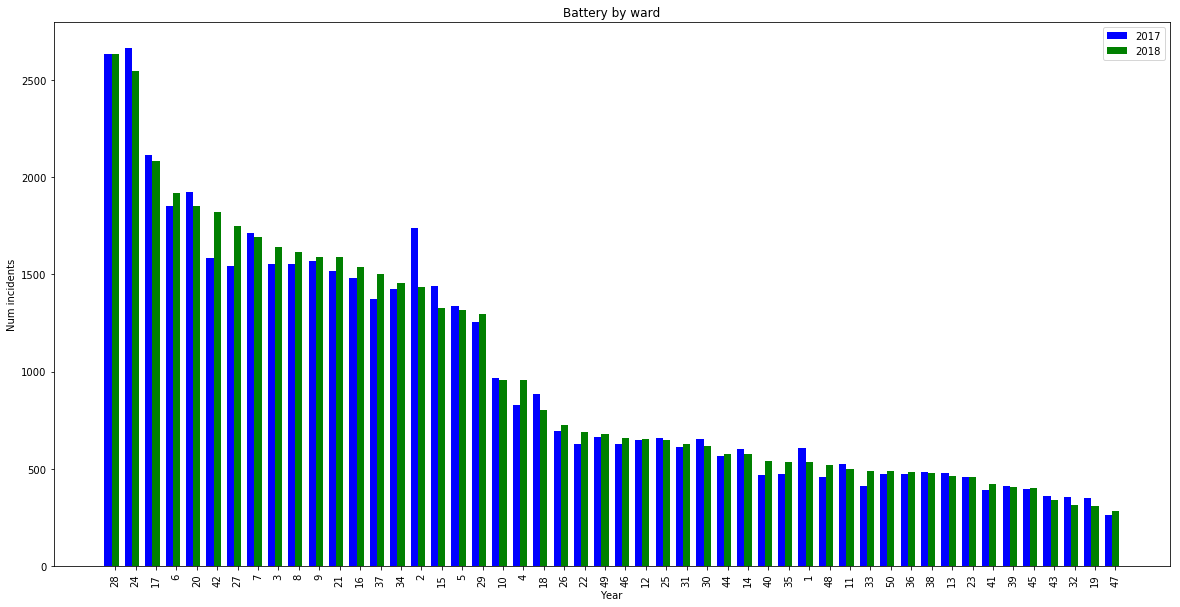

In [18]:
n = ward_year_sorted.shape[0]
num_2017 = ward_year_sorted['2017']
num_2018 = ward_year_sorted['2018']
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n)
bar_width = 0.35
rects1 = plt.bar(index, num_2017, bar_width,
color='b',
label='2017')

rects2 = plt.bar(index + bar_width, num_2018, bar_width,
color='g',
label='2018')

plt.xlabel('Year')
plt.ylabel('Num incidents')
plt.title('Battery by ward')
plt.xticks(index + bar_width, list(ward_year_sorted.index),rotation=90)
plt.legend()
plt.show()

Similar to homicide, looking across the two years the wards with the highest number of batteries looks overall similar, with some small differences.

Let's look at the deceptive practice vs. sex offense

In [19]:
deceptive = results_df.loc[results_df["primary_type"] == 'DECEPTIVE PRACTICE']
deceptive = deceptive.groupby(["ward","year"]).size()
deceptive = deceptive.unstack()
deceptive_sorted = deceptive.sort_values(by='2018',ascending=False)
deceptive_sorted.head(5)

year,2017,2018
ward,,
42,2665,2901
2,1131,1040
27,520,615
44,455,488
21,416,488


From above, we can see ward 42 had the highest instances of deceptive practice, followed by ward 2.

In [20]:
sex_offense = results_df.loc[results_df["primary_type"] == 'SEX OFFENSE']
sex_offense = sex_offense.groupby(["ward","year"]).size()
sex_offense = sex_offense.unstack()
sex_offense = sex_offense.sort_values(by='2018',ascending=False)
sex_offense.head(5)

year,2017,2018
ward,,
42,45,62
2,31,45
24,38,38
28,28,35
49,27,34


It appears the same types of blocks get both sex offense and deceptive practice, but the latter is more commonly classified.